In [1]:
using LatinHypercubeSampling
using Surrogates
using Interact, Plots
using LinearAlgebra
import Random
using MLBase
using LaTeXStrings
include("gridsamp.jl")
Random.seed!(1234);

WebIO._IJuliaInit()

In [2]:
lb = [-2.0,-2.0]
ub = [2.0,2.0]
n_samples = 200;

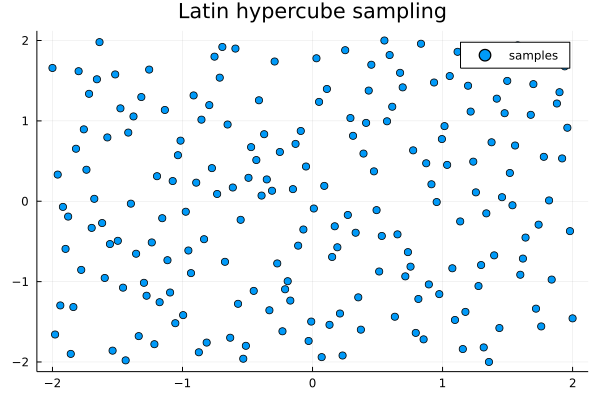

In [3]:
plan, _ = LHCoptim(n_samples,2,1000);
lhs = scaleLHC(plan,[(lb[1],ub[1]),(lb[2],ub[2])])
plot(lhs[:,1], lhs[:,2], seriestype = :scatter, label = "samples", title = "Latin hypercube sampling")

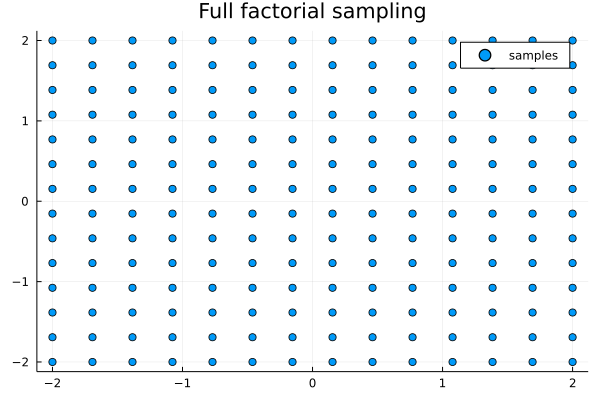

In [4]:
bounds = Matrix{Float64}(undef,2,2)
bounds[1,:] = lb
bounds[2,:] = ub

n_levels = [Int(round(sqrt(n_samples))),Int(round(sqrt(n_samples)))]
full_fact = gridsamp(bounds,n_levels)
plot(full_fact[:,1], full_fact[:,2], seriestype = :scatter, label = "samples", title = "Full factorial sampling")

In [5]:
ui = @manipulate throttle=.05 for n=3:1:100
    include("gridsamp.jl")
    lb = [-2.0,-2.0]
    ub = [2.0,2.0]

    Random.seed!(1234)
    plan, _ = LHCoptim(n,2,10);
    lhs = scaleLHC(plan,[(lb[1],ub[1]),(lb[2],ub[2])])
    p1 = plot(lhs[:,1], lhs[:,2], seriestype = :scatter, title = "Latin hypercube sampling")
    

    bounds = Matrix{Float64}(undef,2,2)
    bounds[1,:] = lb
    bounds[2,:] = ub

    n_levels = [Int(round(sqrt(n))),Int(round(sqrt(n)))]
    full_fact = gridsamp(bounds,n_levels)
    p2 = plot(full_fact[:,1], full_fact[:,2], seriestype = :scatter, title = "Full factorial sampling")
    
    plot(p1, p2, size = (900, 300), layout = grid(1, 2, widths=[0.5 ,0.5]), legend = false)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 98, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
49, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/khalil/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/khalil/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/khalil/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/home/khalil/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/home/khalil/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f5b7a1699f0, Task (runnable) @0x00007f5b7a1699f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43

In [6]:
# convert 2D matrix rows to Tuples
function toTuple(A::Array{T,2}) where {T<:Any}
    return [tuple(A[c,:]...) for c in 1:size(A,1)]
end

function rosenbrock(x)
    z = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
end

z = mapslices(rosenbrock,lhs; dims=2)

# train the model
kriging_surrogate = Kriging(toTuple(lhs), vec(z), lb, ub, p=[2.0, 2.0], theta=[0.03, 0.003]);

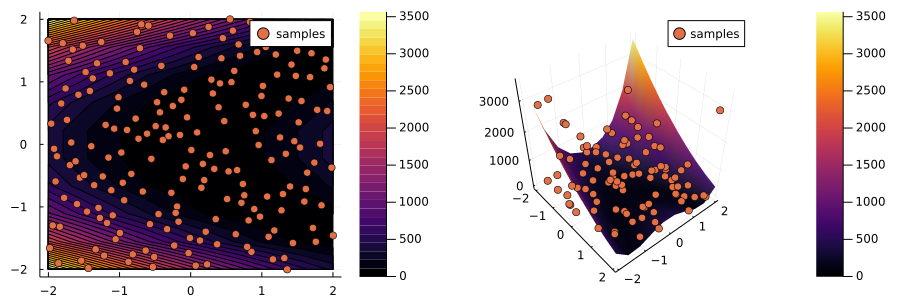

In [7]:
bounds_s = Matrix{Float64}(undef,2,2)
bounds_s[1,:] = lb
bounds_s[2,:] = ub
ns = [10,10]
Xs = gridsamp(bounds_s,ns)

# Predictions
zs = kriging_surrogate.(toTuple(Xs))
xs = LinRange(bounds_s[1,1],bounds_s[2,1],10)
ys = LinRange(bounds_s[1,2],bounds_s[2,2],10)

# contour plot
p1 = contour(xs, ys, vec(zs), fill = true, levels = 30)
scatter!(lhs[:,1], lhs[:,2], seriestype = :scatter, label = "samples");

# Surface plot
p2 = plot(xs, ys, vec(zs),st=:surface,camera=(50,40))
scatter3d!(lhs[:,1], lhs[:,2], vec(zs), label = "samples");

# combined plot
plot(p1, p2, size = (900, 300), layout = grid(1, 2, widths=[0.5 ,0.5]))

In [8]:
ui = @manipulate throttle=.05 for n=10:10:100, θ=1e-3:1e-3:1e-2
    include("gridsamp.jl")
    lb = [-2.0,-2.0]
    ub = [2.0,2.0]

    Random.seed!(1234)
    plan, _ = LHCoptim(n,2,10);
    lhs = scaleLHC(plan,[(lb[1],ub[1]),(lb[2],ub[2])])

    z = mapslices(rosenbrock,lhs; dims=2)

    # train the model
    kriging_surrogate = Kriging(toTuple(lhs), vec(z), lb, ub, p=[2.0, 2.0], theta=[θ, θ])

    # plotting
    bounds_s = Matrix{Float64}(undef,2,2)
    bounds_s[1,:] = lb
    bounds_s[2,:] = ub
    ns = [10,10]
    Xs = gridsamp(bounds_s,ns)

    # Predictions
    zs = kriging_surrogate.(toTuple(Xs))
    xs = LinRange(bounds_s[1,1],bounds_s[2,1],10)
    ys = LinRange(bounds_s[1,2],bounds_s[2,2],10)

    # contour plot
    p1 = contour(xs, ys, vec(zs), fill = true, levels = 30)
    scatter!(lhs[:,1], lhs[:,2], seriestype = :scatter, label = "samples");

    # Surface plot
    p2 = plot(xs, ys, vec(zs),st=:surface,camera=(50,40), label = "prediction")
    scatter3d!(lhs[:,1], lhs[:,2], vec(zs), label = "samples");

    # combined plot
    plot(p1, p2, size = (1300, 500), layout = grid(1, 2, widths=[0.5 ,0.5]))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 10, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
5, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/khalil/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/khalil/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/khalil/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/home/khalil/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/home/khalil/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f5b7c7882f0, Task (runnable) @0x00007f5b7c7882f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"10\",\"20\",\"30\",\"40\",\"50\",\"60\",\"70\",\"80\",\"90\",\"100\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"13660039025500609242\",\"id\":\"17774885908789693585\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"13660039025

In [9]:
# rows = collect(LOOCV(floor(size(lhs)[1])))

function KfoldCV(X::AbstractMatrix,Y::AbstractMatrix,n_folds::Int64,θ::Float64)::Float64
    
    rows = collect(Kfold(size(lhs)[1],n_folds))

    MSE = 0
    for fold in rows
        # train the model
        kriging_surrogate = Kriging(toTuple(X[fold,:]), vec(Y[fold]), lb, ub, p=[2.0, 2.0], theta=[θ, θ]);
    
        # Predictions
        test = deleteat!([1:1:size(X)[1];], fold)
        Y_predict = kriging_surrogate.(toTuple(X[test,:]))
    
        # error
        MSE += norm(Y_predict - Y[test])
    end
    
    MSE /= n_folds
end

error_θ = [KfoldCV(lhs,z,5,θ) for θ=1e-2:5e-3:1e-0];

In [10]:
function error_sampling(X::AbstractMatrix,Y::AbstractMatrix,n::Int64)::Float64
    n = min(160,n) # cap n at 160

    # train the model
    kriging_surrogate = Kriging(toTuple(X[1:n,:]), vec(Y[1:n]), lb, ub, p=[2.0, 2.0], theta=[0.03, 0.03]);

    # Predictions
    Y_predict = kriging_surrogate.(toTuple(X[160:end,:]))

    # error
    MSE = norm(Y_predict - Y[160:end])
end

error_n = [error_sampling(lhs,z,n) for n=20:2:160];

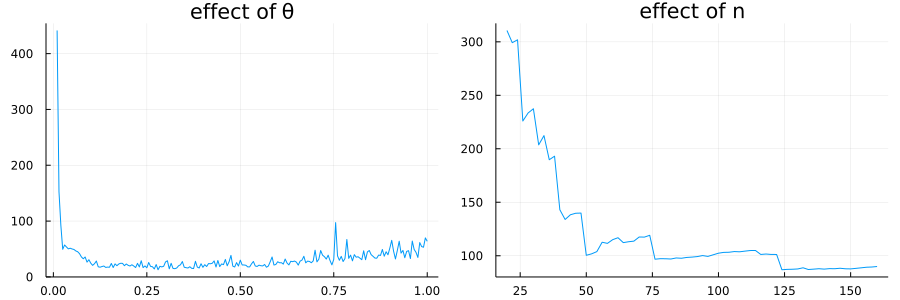

In [11]:
# theta plot
p1 = plot(1e-2:5e-3:1e-0, error_θ, st=:line, title="effect of \\theta" );

# samples plot
p2 = plot(20:2:160, error_n, st=:line, title="effect of n");

# combined plot
plot(p1, p2, size = (900, 300), layout = grid(1, 2, widths=[0.5 ,0.5]), legend=false)